# 07MIAR - Redes Neuronales y Deep Learning: Proyecto de programación "*Deep Vision in classification tasks*"

# IMPORTACIÓN DE LIBRERÍAS Y CONFIGURACIÓN

In [1]:
# Librerías de ciencia de datos y manipulación de datos
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from pathlib import Path

# Librerías de visualización
import matplotlib.pyplot as plt
import cv2

# TensorFlow y Keras para construir y entrenar redes neuronales
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Model
from keras import regularizers

# Métricas de clasificación
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Carga de datos desde Kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"soledadmurias","key":"996c5f05f046c6d788f6e7645306dc75"}'}

In [3]:
# Configuración de Kaggle para descargar datos
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tr1gg3rtrash/yoga-posture-dataset
!unzip -qq yoga-posture-dataset.zip -d my_dataset

Dataset URL: https://www.kaggle.com/datasets/tr1gg3rtrash/yoga-posture-dataset
License(s): CC0-1.0
 99% 444M/447M [00:22<00:00, 21.6MB/s]
100% 447M/447M [00:22<00:00, 20.9MB/s]


# CARGA Y PREPARACIÓN DE LOS DATOS

In [4]:
# Definir el directorio de imágenes descargadas
image_dir = Path("my_dataset/yoga_posture")

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, walk_through_dir

--2024-11-09 17:08:41--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-11-09 17:08:41 (110 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [5]:
dataset = "my_dataset"
walk_through_dir(dataset)

image_dir = Path(dataset)

# Obtener ruta de cada imagen y etiqueta
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name = 'Filepath').astype(str)
labels = pd.Series(labels, name = 'Label')

# Concatener ruta y etiqueta
image_df = pd.concat([filepaths, labels], axis = 1)

image_df

There are 47 directories and 1 images in 'my_dataset'.
There are 0 directories and 59 images in 'my_dataset/Ardha Chandrasana'.
There are 0 directories and 54 images in 'my_dataset/Dhanurasana'.
There are 0 directories and 43 images in 'my_dataset/Pincha Mayurasana'.
There are 0 directories and 23 images in 'my_dataset/Trikonasana'.
There are 0 directories and 53 images in 'my_dataset/Eka Pada Rajakapotasana'.
There are 0 directories and 61 images in 'my_dataset/Virabhadrasana Two'.
There are 0 directories and 20 images in 'my_dataset/Sivasana'.
There are 0 directories and 81 images in 'my_dataset/Utkatasana'.
There are 0 directories and 85 images in 'my_dataset/Garudasana'.
There are 0 directories and 81 images in 'my_dataset/Baddha Konasana'.
There are 0 directories and 62 images in 'my_dataset/Salamba Bhujangasana'.
There are 0 directories and 71 images in 'my_dataset/Halasana'.
There are 0 directories and 64 images in 'my_dataset/Utthita Hasta Padangusthasana'.
There are 0 director

,Filepath,Label
0,my_dataset/Utkatasana/File42.jpg,Utkatasana
1,my_dataset/Utkatasana/File68.jpg,Utkatasana
2,my_dataset/Baddha Konasana/File59.jpg,Baddha Konasana
3,my_dataset/Baddha Konasana/File21.jpg,Baddha Konasana
4,my_dataset/Baddha Konasana/File49.jpg,Baddha Konasana
...,...,...
4664,my_dataset/Alanasana/File13.png,Alanasana
4665,my_dataset/Alanasana/File2.png,Alanasana
4666,my_dataset/Alanasana/File18.png,Alanasana
4667,my_dataset/Alanasana/File11.png,Alanasana


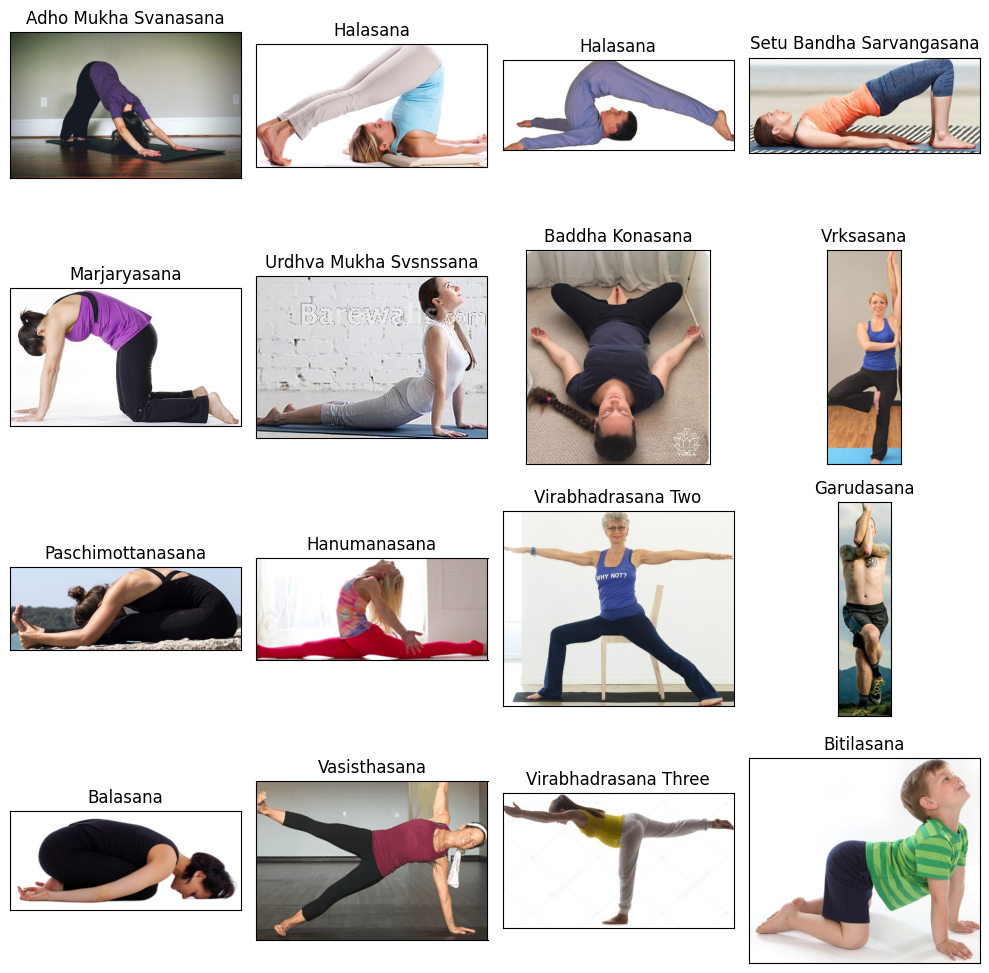

In [6]:
# Mostramos 16 imagenes a modelo de ejemplo con su respectiva categoría
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize = (10, 10),
                        subplot_kw = {'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [7]:
# Crear un DataFrame con las rutas y etiquetas para fácil manipulación
image_df = pd.DataFrame({"Filepath": filepaths, "Label": labels})

In [8]:
# Separación en datos de entrenamiento y prueba (80% para entrenamiento y 20% para prueba)
train_df, test_df = train_test_split(image_df, test_size=0.2, stratify=labels, random_state=42)

# CONFIGURACIÓN DE GENERADORES DE IMÁGENES

In [9]:
# Generador de datos de entrenamiento con aumentación para mejorar generalización del modelo
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2,  # 20% de datos de entrenamiento reservados para validación
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Generador de datos de prueba (solo preprocesamiento, sin aumentación)
test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

# Generadores de imágenes de entrenamiento, validación y prueba
train_images = train_datagen.flow_from_dataframe(
    train_df, x_col="Filepath", y_col="Label", target_size=(224, 224), color_mode="rgb",
    class_mode="categorical", batch_size=32, shuffle=True, seed=42, subset="training"
)

train_generator = train_datagen.flow_from_directory(
    directory='my_dataset',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    directory='my_dataset',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 2988 validated image filenames belonging to 43 classes.
Found 2227 images belonging to 47 classes.
Found 529 images belonging to 47 classes.


In [10]:
val_images = train_datagen.flow_from_dataframe(
    train_df, x_col="Filepath", y_col="Label", target_size=(224, 224), color_mode="rgb",
    class_mode="categorical", batch_size=32, shuffle=True, seed=42, subset="validation"
)

test_images = test_datagen.flow_from_dataframe(
    test_df, x_col="Filepath", y_col="Label", target_size=(224, 224), color_mode="rgb",
    class_mode="categorical", batch_size=32, shuffle=False
)

Found 747 validated image filenames belonging to 43 classes.
Found 934 validated image filenames belonging to 43 classes.


# ESTRATEGIA 1: ENTRENAR DESDE CERO

## ARQUITECTURA DEL MODELO CNN

In [11]:
# Definir el número de clases a partir de los datos de entrenamiento
num_classes = len(train_images.class_indices)

# Arquitectura del modelo usando Keras Sequential
model = Sequential([
    # Primera capa de convolución
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=l2(0.0001)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.1),

    # Segunda capa de convolución
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.2),

    # Tercera capa de convolución
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.3),

    # Cuarta capa de convolución adicional
    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.4),

    # Capa fully connected
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Dropout(0.5),

    # Capa de salida
    Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1.  Tamaño de Filtros: Los filtros (3,3) son generalmente óptimos para detectar bordes y patrones en imágenes de tamaño medio.
Batch Normalization y Dropout: Juntos, combaten el sobreajuste y estabilizan el aprendizaje.
2.  Learning Rate (Adam): Comenzamos con 0.001, pero este parámetro se puede ajustar con experimentación en futuras pruebas si el modelo muestra un aprendizaje lento o inestable.
3.  Esta arquitectura y los hiperparámetros permiten una buena generalización al evitar el sobreajuste y aprender patrones profundos en las imágenes de posturas de yoga.

4.   Capas de convolución: Tres capas de convolución permiten a la red capturar patrones complejos y profundos de las imágenes.
5.   MaxPooling: La reducción de dimensionalidad ayuda a reducir la carga computacional y a captar características invariantes a traslaciones.
6.   Regularización y dropout: Usamos l2 y dropout en cada capa para reducir el sobreajuste. l2 penaliza los pesos excesivamente altos, mientras que el dropout apaga neuronas aleatorias para forzar a la red a ser más robusta.
7.   Batch Normalization: Acelera la convergencia y mejora la estabilidad del entrenamiento.

In [12]:
# Resumen del modelo para ver la estructura
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 111, 111, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 54, 54, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 26, 26, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,718,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 5,115,115 (19.51 MB)

 Trainable params: 5,113,899 (19.51 MB)

 Non-trainable params: 1,216 (4.75 KB)

## COMPILACIÓN Y OPTIMIZACIÓN DEL MODELO

In [13]:
# Compilación del modelo con optimizador Adam y función de pérdida categórica
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Definir callbacks para control del entrenamiento
early_stopping = EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)

In [14]:
# Entrenamiento del modelo usando los generadores de datos
history = model.fit(
    train_images,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data = val_images,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs = 100,
    callbacks = [
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "yoga_classification")    ]
)

Saving TensorBoard log files to: training_logs/yoga_classification/20241109-170844
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


69/69 ━━━━━━━━━━━━━━━━━━━━ 77s 826ms/step - accuracy: 0.0437 - loss: 4.7487 - val_accuracy: 0.0352 - val_loss: 4.2135
Epoch 2/100
25/69 ━━━━━━━━━━━━━━━━━━━━ 16s 382ms/step - accuracy: 0.0616 - loss: 4.3359

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


69/69 ━━━━━━━━━━━━━━━━━━━━ 13s 196ms/step - accuracy: 0.0614 - loss: 4.2608 - val_accuracy: 0.0213 - val_loss: 4.3837
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 106s 688ms/step - accuracy: 0.0760 - loss: 4.0310 - val_accuracy: 0.0293 - val_loss: 4.2481
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 13s 185ms/step - accuracy: 0.1017 - loss: 3.8384 - val_accuracy: 0.0383 - val_loss: 4.4057
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 48s 658ms/step - accuracy: 0.1032 - loss: 3.7844 - val_accuracy: 0.0781 - val_loss: 3.9075
Epoch 6/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 12s 179ms/step - accuracy: 0.1258 - loss: 3.5410 - val_accuracy: 0.0766 - val_loss: 4.0855
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 50s 673ms/step - accuracy: 0.1400 - loss: 3.5228 - val_accuracy: 0.1113 - val_loss: 3.7196
Epoch 8/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 31s 455ms/step - accuracy: 0.1659 - loss: 3.3367 - val_accuracy: 0.0936 - val_loss: 3.8047
Epoch 9/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 49s 658ms/step - accuracy: 0.1783 - loss: 3.2723 - val_accurac

## EVALUACIÓN DEL MODELO


El conjunto de datos de prueba se utilizará para evaluar el rendimiento del modelo. Una de las métricas que se probará es la precisión, que mide la fracción de predicciones correctas realizadas por el modelo. Otras métricas son las siguientes:

* **Precisión (P)**: La fracción de verdaderos positivos (TP, predicciones correctas) sobre el total de resultados relevantes, es decir, la suma de TP y falsos positivos (FP). En problemas de clasificación multiclase, la precisión se promedia entre las clases. La fórmula para la precisión es la siguiente.

* **Recall (R)**: La fracción de verdaderos positivos (TP) sobre el total de TP y falsos negativos (FN). En problemas de clasificación multiclase, la exhaustividad se promedia entre todas las clases. La fórmula para el recall es la siguiente.

* **F1 Score (F1)**: La media armónica de la precisión y la exhaustividad. En problemas de clasificación multiclase, F1 se promedia entre todas las clases. La fórmula para la puntuación F1 es la siguiente.

In [15]:
# Evaluación en el conjunto de prueba
results = model.evaluate(test_images, verbose=0)
print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 1.79242
Test Accuracy: 60.28%


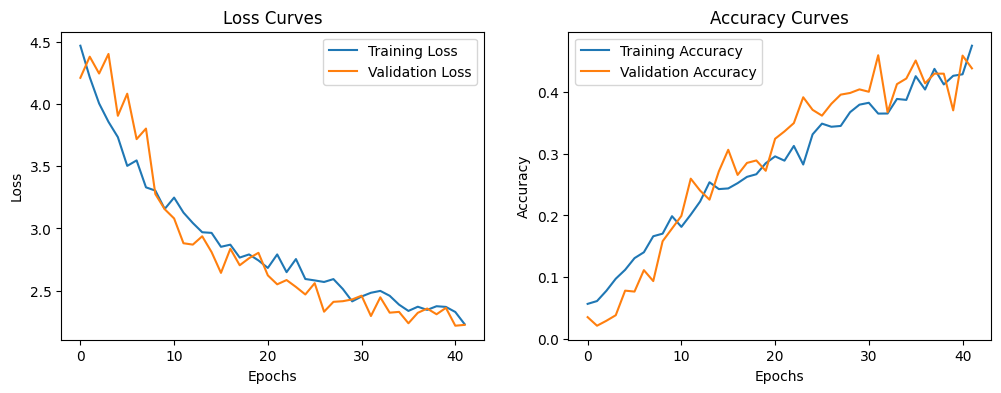

In [16]:

# Función para graficar las curvas de precisión y pérdida
def plot_loss_curves(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curves')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curves')
    plt.show()

# Llamar a la función para graficar
plot_loss_curves(history)

In [17]:
# Predicción en el conjunto de prueba
y_pred = np.argmax(model.predict(test_images), axis=1)
y_true = test_images.classes

# Imprimir informe de clasificación
print(classification_report(y_true, y_pred, target_names=test_images.class_indices.keys()))


30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 180ms/step
                               precision    recall  f1-score   support

         Adho Mukha Svanasana       0.38      0.89      0.54        28
         Adho Mukha Vrksasana       0.44      0.29      0.35        24
                    Alanasana       0.00      0.00      0.00         2
                 Anjaneyasana       0.41      0.52      0.46        25
            Ardha Chandrasana       0.80      0.40      0.53        20
         Ardha Matsyendrasana       0.54      0.53      0.54        36
               Ardha Navasana       0.00      0.00      0.00         1
      Ardha Pincha Mayurasana       0.37      0.80      0.51        20
            Ashta Chandrasana       0.00      0.00      0.00         1
              Baddha Konasana       0.82      0.32      0.46        28
                     Bakasana       0.87      0.42      0.57        31
                     Balasana       0.58      0.39      0.47        28
                   Bitilasana      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


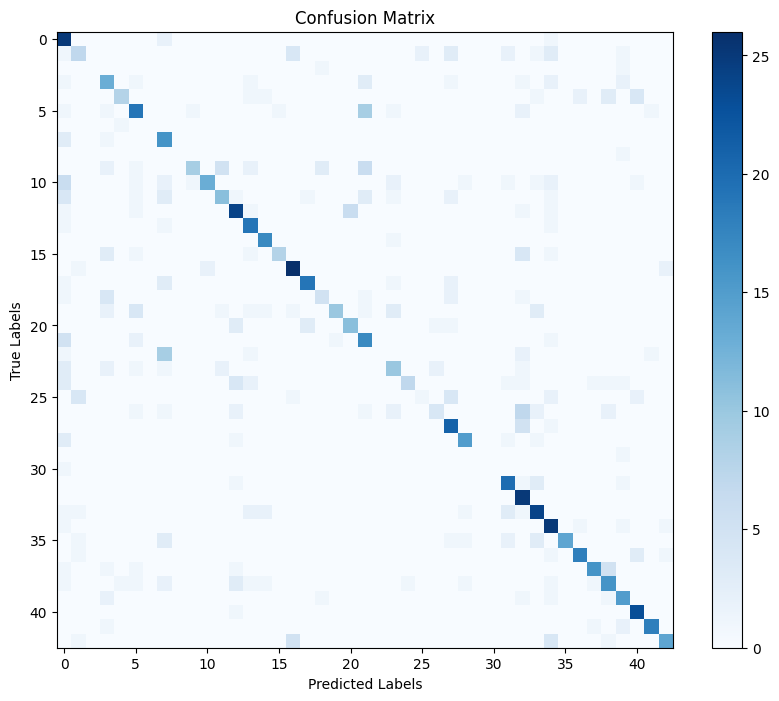

In [18]:
# Visualizar matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.colorbar()
plt.show()